# 0.0 Imports

In [151]:
%config Completer.use_jedi = False

import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib
from  IPython.core.display import HTML
from IPython.display import Image
from scipy                 import stats as ss
from tabulate              import tabulate


## 0.1. Helper Functions

In [152]:
def plot_correlation_heatmap(corr_matrix, plt, sns):
    
    """
        Cria e plot heatmap contendo apenas a matriz triangular inferior.        
    """
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(16, 12))

    sns.heatmap(corr_matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap='vlag')

    plt.show();    
    
    

In [153]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [154]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
994240,446,1,2013-01-21,6610,861,1,1,0,0,a,a,340.0,10.0,2000.0,1,31.0,2013.0,"Feb,May,Aug,Nov"


# 1.0. Descrição dos Dados

In [155]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [156]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [157]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [158]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old ))

df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Dimensões dos dados

In [162]:
print(f'Número de linhas: {df1.shape[0]}.')
print(f'Número de colunas: {df1.shape[1]}.')

Número de linhas: 1017209.
Número de colunas: 18.


## 1.3. Tipos de dados

In [163]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Tratamento de valores faltantes

In [161]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
# competition_distance
max_distance = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct',11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['month_map'].sample(5)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)               

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Conversão de tipos

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6. Estatística descritiva dos dados

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

#df1.dtypes

## 1.7. Estatística descritiva

### 1.7.1. Atributos numéricos

In [14]:
def estatistica_descritiva(df):
    
    atributos_numericos = df.select_dtypes(include=['int64', 'float64'])    

    # tendência central
    df_mean = pd.DataFrame(atributos_numericos.apply(np.mean)).T
    df_median = pd.DataFrame(atributos_numericos.apply(np.median)).T

    # métricas de dispersão
    df_std = pd.DataFrame(atributos_numericos.apply(np.std)).T
    df_min = pd.DataFrame(atributos_numericos.apply(np.min)).T
    df_max = pd.DataFrame(atributos_numericos.apply(np.max)).T
    df_range = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T

    df_stat = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
    df_stat.columns = ['Atributos', 'min', 'max', 'intervalo', 'média', 'std', 'mediana',   'skew', 'kurtosis']

    return df_stat

display(estatistica_descritiva(df1))

,Atributos,min,max,intervalo,média,std,mediana,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


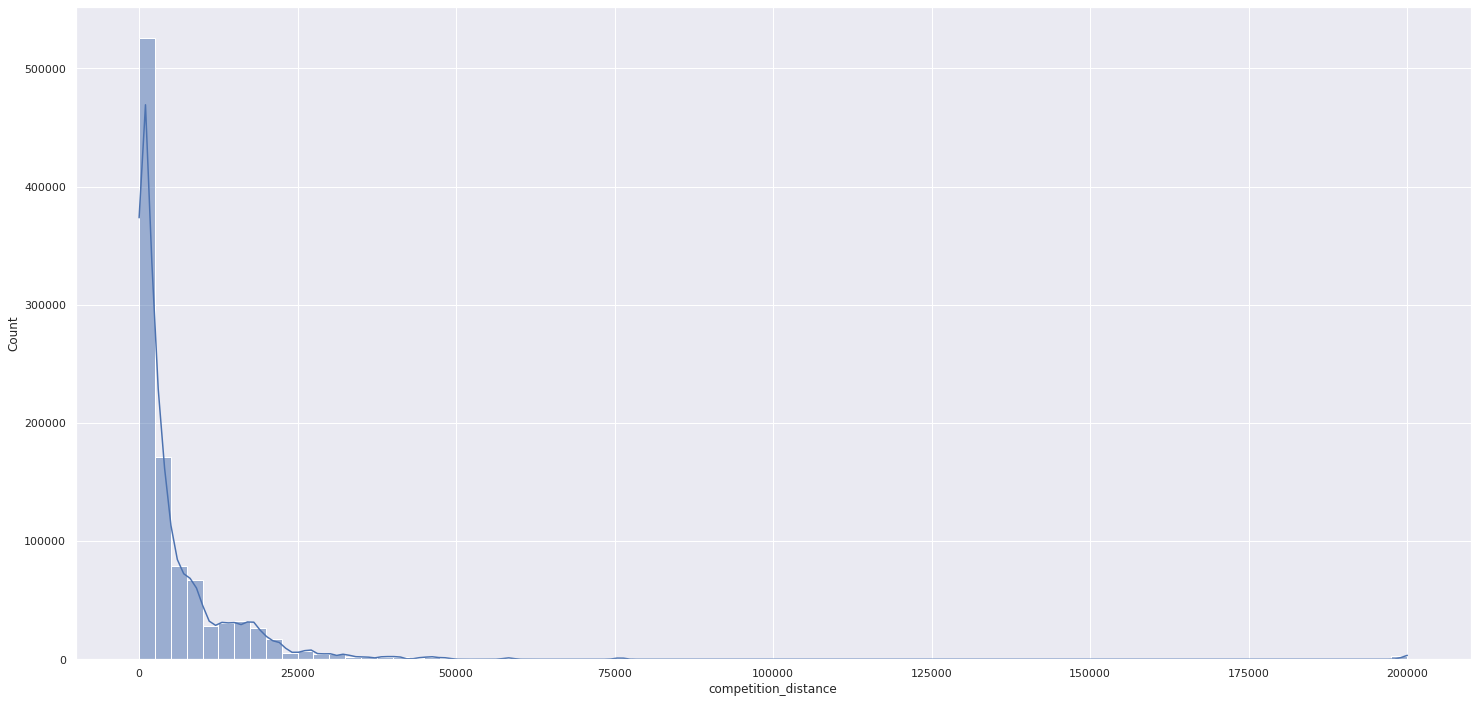

In [83]:
sns.histplot(data=df1, x='competition_distance', kde=True, bins=80);

### 1.7.2 - Atributos categóricos

In [16]:
atributos_categoricos = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

atributos_categoricos.apply(lambda x: x.unique().shape[0])



state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

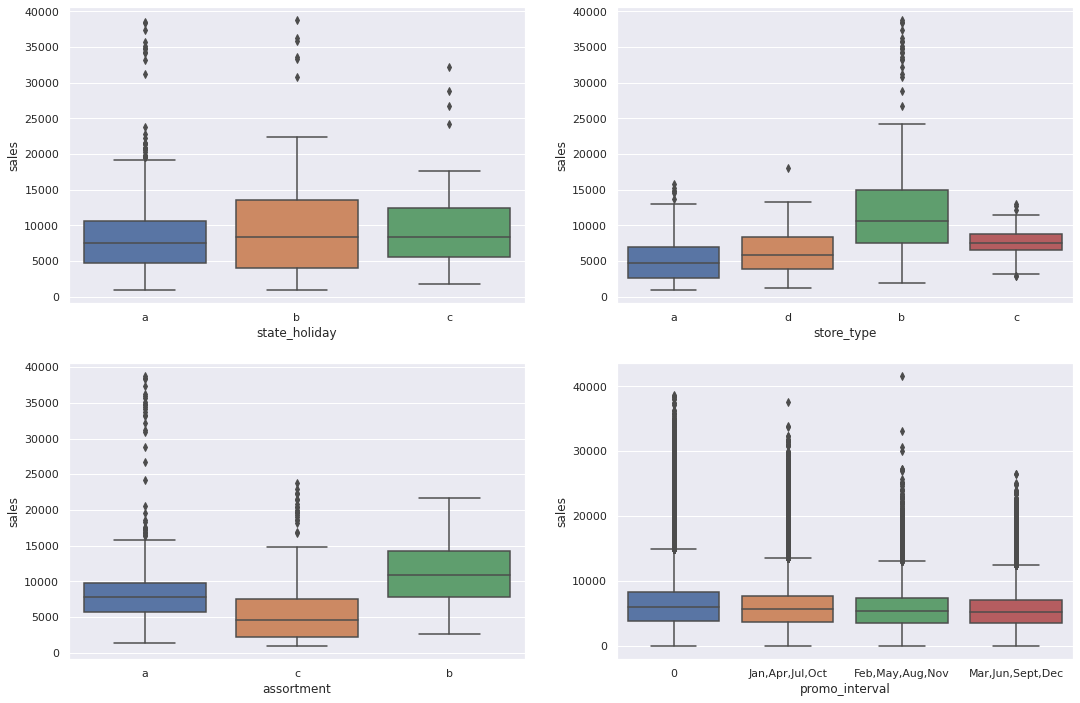

In [84]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

fig = plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
sns.boxplot(data=aux1, x='state_holiday', y='sales');

plt.subplot(2,2,2)
sns.boxplot(data=aux1, x='store_type', y='sales');

plt.subplot(2,2,3)
sns.boxplot(data=aux1, x='assortment', y='sales');


plt.subplot(2,2,4)
sns.boxplot(data=df1, x='promo_interval', y='sales');



*pontos no boxplot* = pontos pelo menos 3x maior que o desvio padrão.

# 2.0. Feature engineering

In [18]:
df2 = df1.copy()

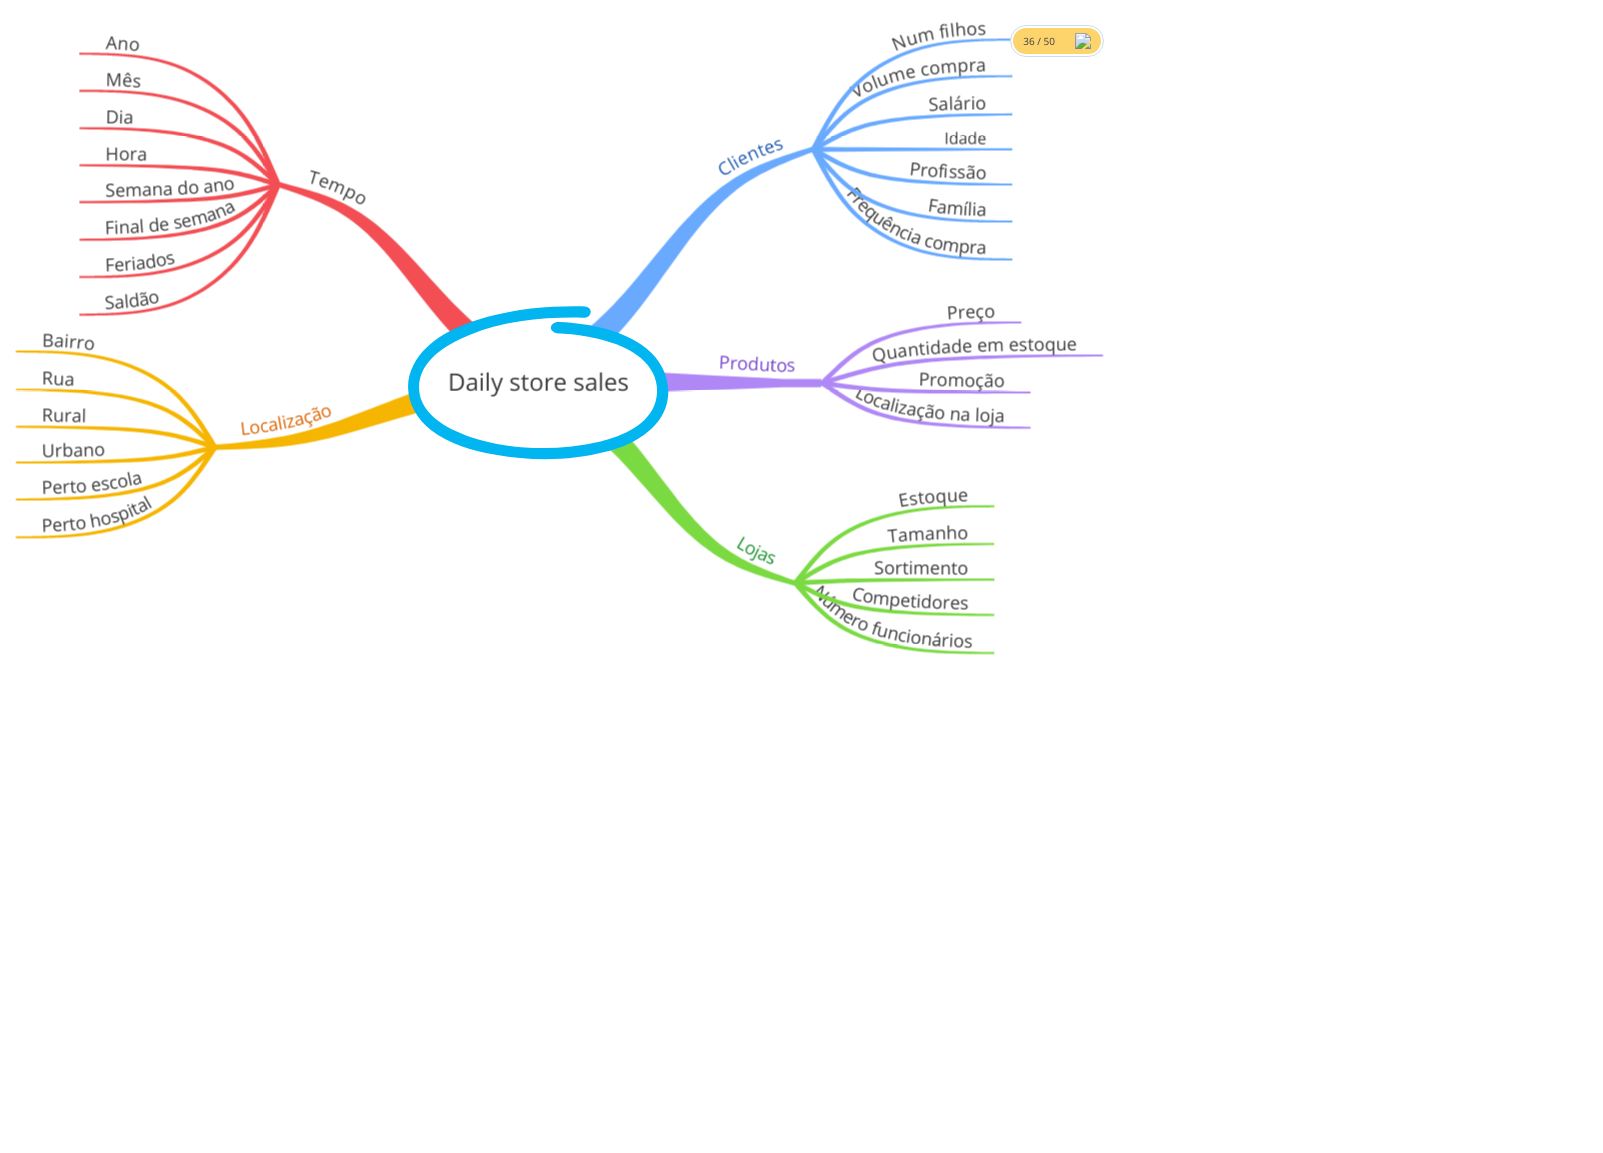

In [19]:
Image('../img/hipoteses.png')

## 2.1 Criação das hipóteses

### 2.1.1 Hipóteses loja

**1.** Lojas com mais funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas de maior porte deveriam vender mais.

**4.** Lojas de menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo deveriam vender menos.


### 2.1.1 Hipóteses produto


**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que têm preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.1 Hipóteses tempo

**1.** Lojas com mais feriados deveriam vender menos.

**2.** Lojas deveriam vender mais no segundo semestre do ano.

**3.** Lojas deveriam vender mais nos fins de semana.

**4.** Lojas abertas no feriado de Natal deveriam vender mais.

**5.**. Lojas deveriam vender mais ao longo dos anos.

**6.**. Lojas deveriam vender mais durante os feriados escolares.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

## 2.2 Lista final de hipóteses

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores a mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas no feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender mais nos fins de semana.
12. Lojas que abrem mais nos finais de semana deveriam vender mais.
13. Lojas deveriam vender mais durante os feriados escolares.

## 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month


# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] =  df2.apply(lambda x : datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
# a = basic, b = extra, c = extended
def get_assortment_text(level):
    if level == 'a':
        return 'basic'
    elif level == 'b':
        return 'extra'
    else:
        return 'extended'
    
df2['assortment'] = df2['assortment'].apply(get_assortment_text)

# state holiday
#  a = public holiday, b = Easter holiday, c = Christmas, 0 = None

def get_holiday_description(code):
    if code == 'a':
        return 'public_holiday'
    elif code == 'b':
        return 'easter_holiday'
    elif code == 'c':
        return 'christmas'
    else:
        return 'regular_day'
    
df2['state_holiday'] = df2['state_holiday'].apply(get_holiday_description)


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de variáveis

In [85]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [86]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [87]:
#open != 0
#sales != 0

df3 = df3[(df3['open'] != 0) & (df3['sales'] != 0)]


## 3.2. Seleção das colunas

In [88]:
#customers

cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop(columns=cols_drop)

In [89]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Análise exploratória de dados

In [90]:
df4 = df3.copy()

## 4.1. Análise univariada

### 4.1.1. Response variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

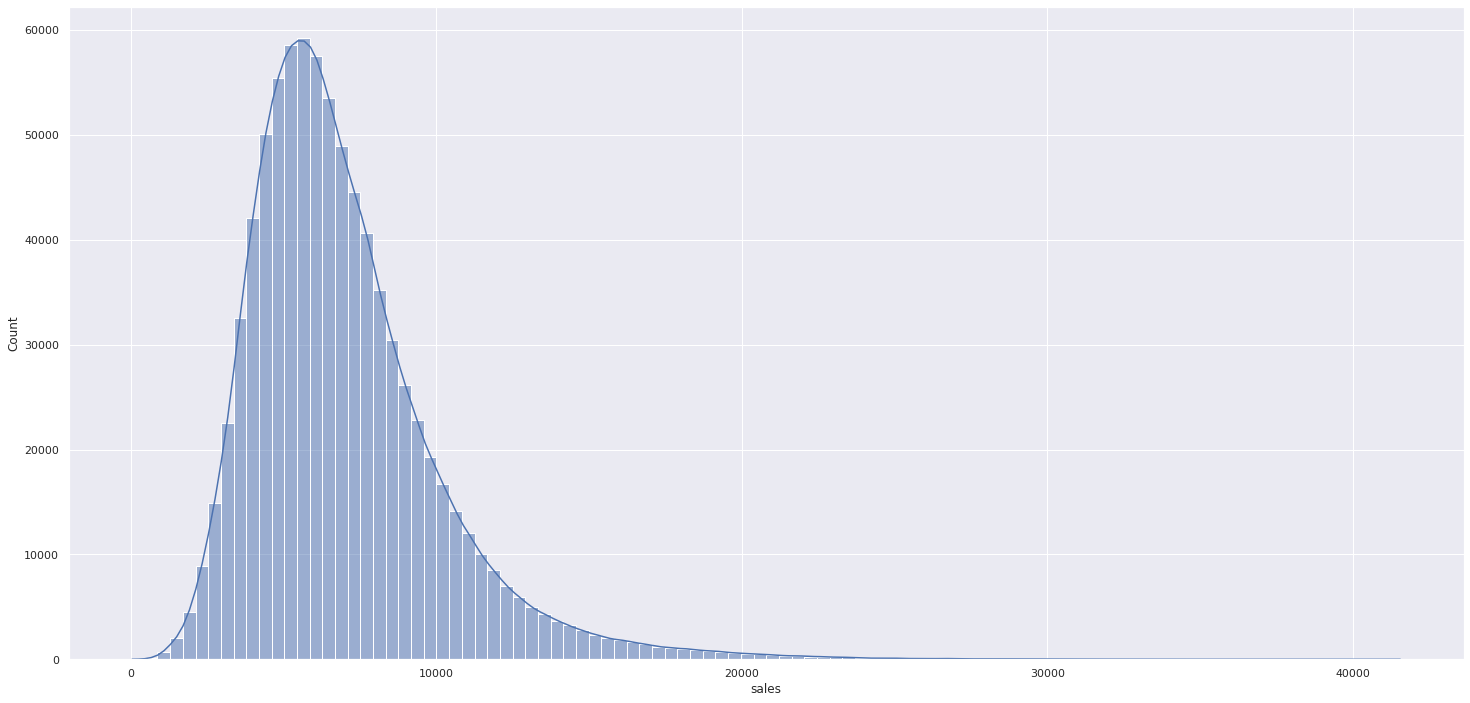

In [82]:
sns.histplot(df4['sales'], bins=100 , kde=True);

### 4.1.2. Numerical variables 

In [71]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).drop(['store'], axis=1)

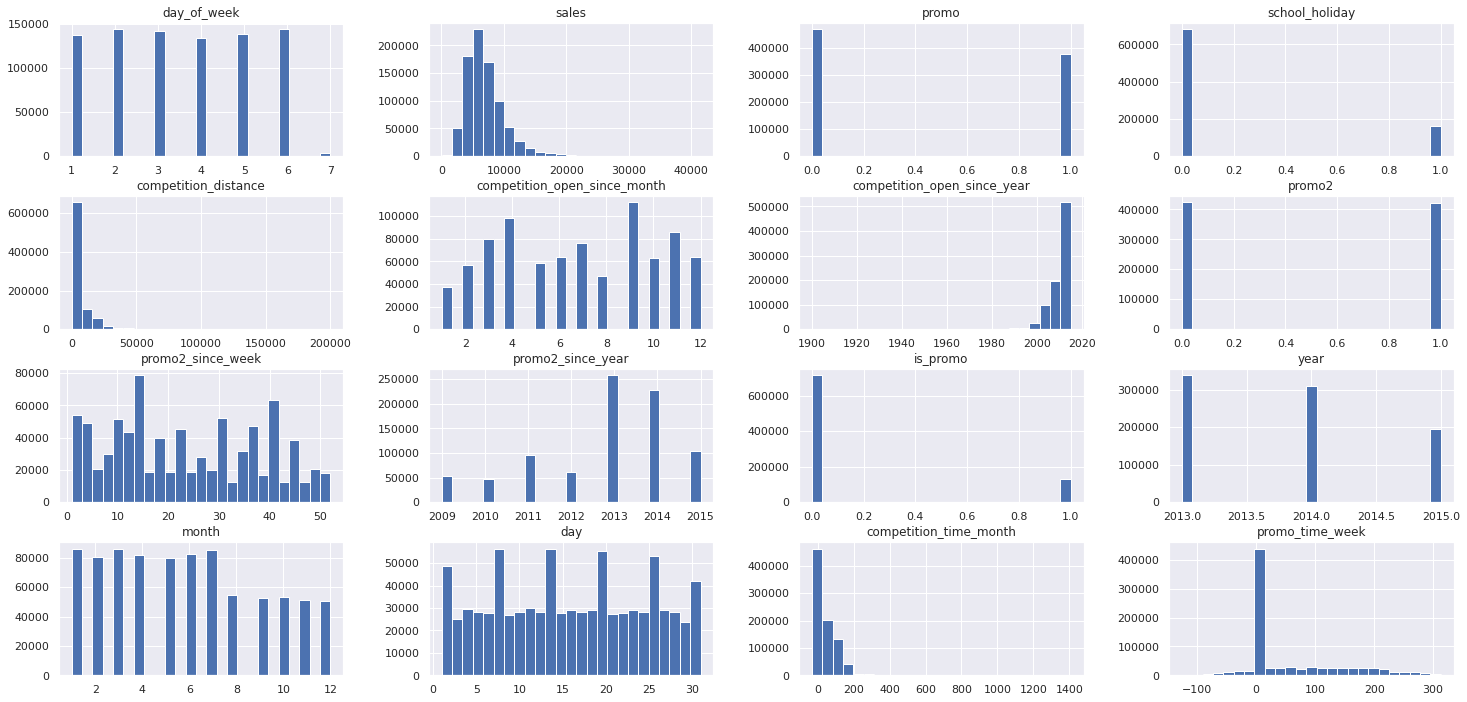

In [81]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical variables 

In [95]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes.head()

,state_holiday,store_type,assortment,week_of_year,year_week
0,regular_day,c,basic,31,2015-30
1,regular_day,a,basic,31,2015-30
2,regular_day,a,basic,31,2015-30
3,regular_day,c,extended,31,2015-30
4,regular_day,a,basic,31,2015-30


In [126]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

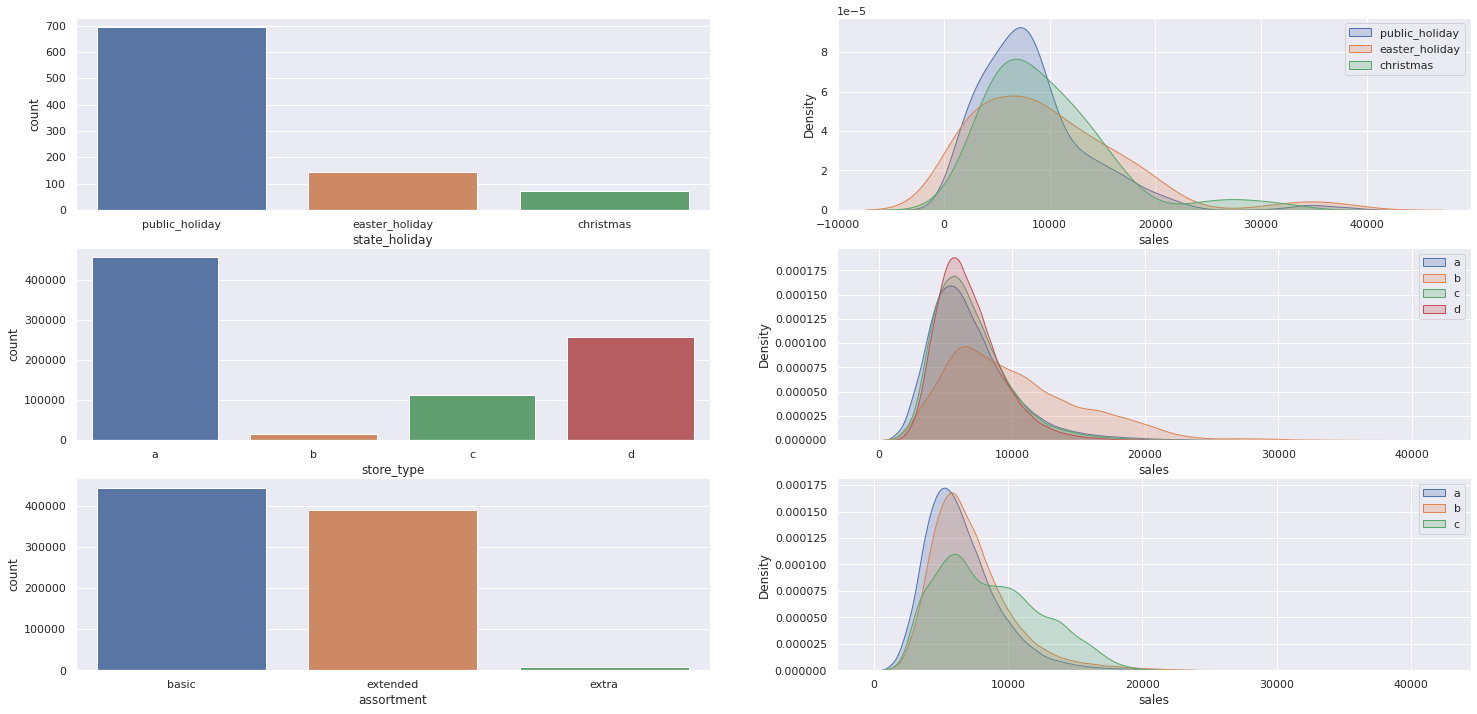

In [124]:
filtered_df4 = df4[(df4['state_holiday'] != 'regular_day')]

plt.subplot(3,2,1)
sns.countplot(data=filtered_df4, x='state_holiday');

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);
plt.legend();

plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', order=['a','b','c','d']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', order=['basic','extended', 'extra']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

plt.legend();




## 4.2 Análise bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**Falsa:** Lojas com maior sortimento vendem menos.

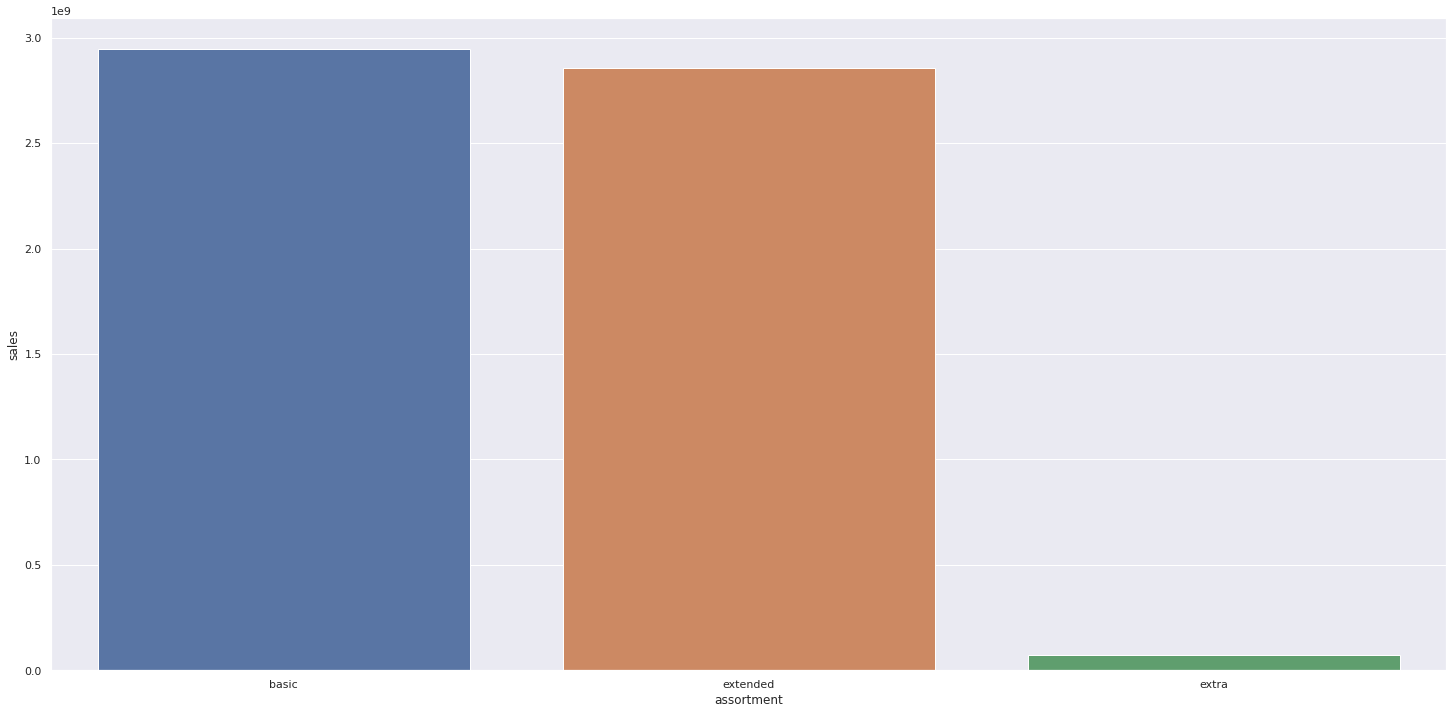

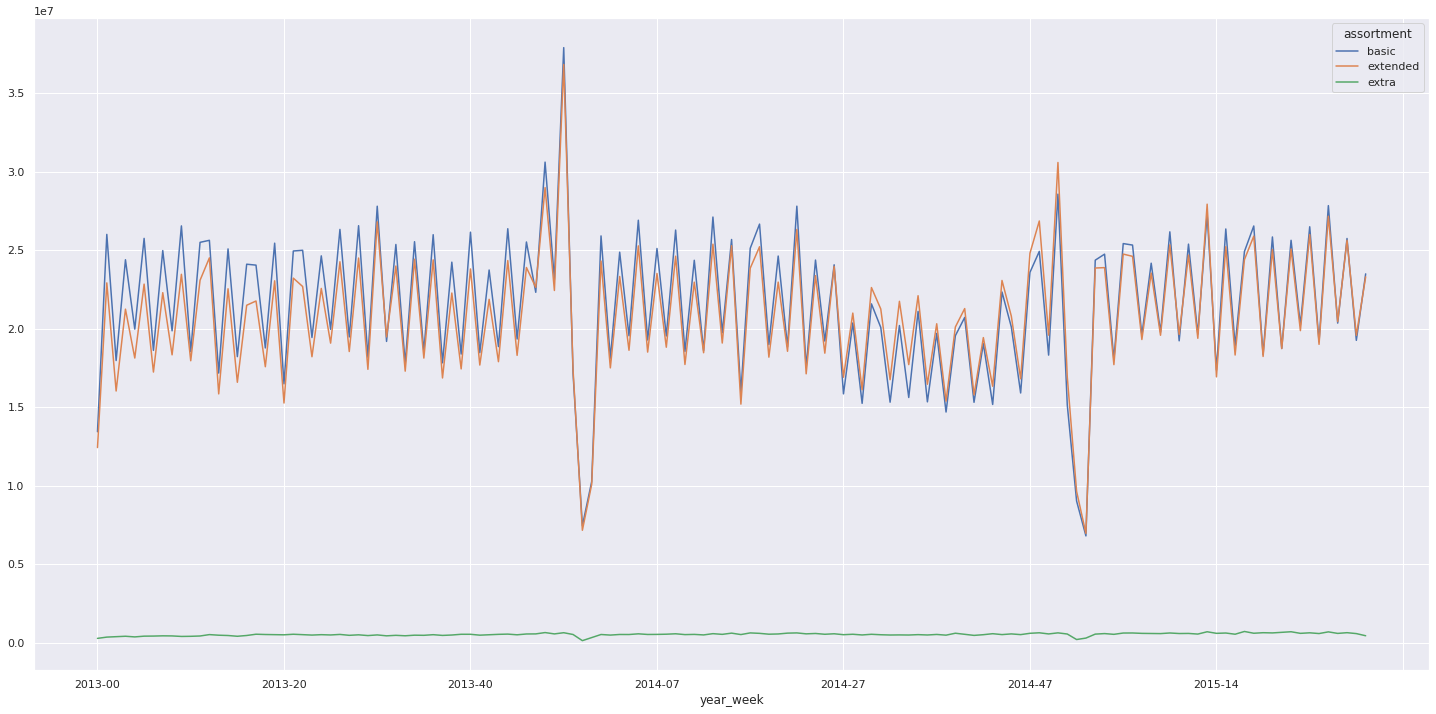

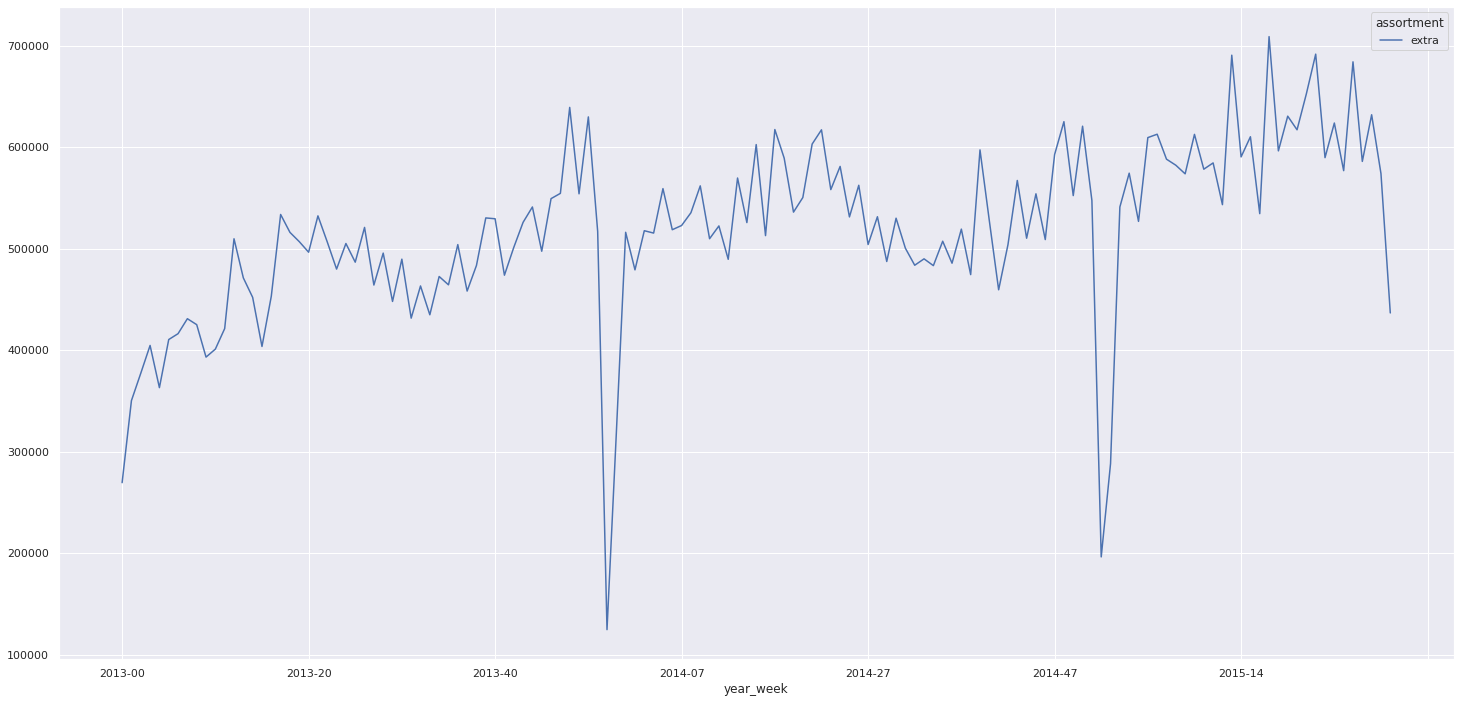

In [140]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(data=aux1, x='assortment', y='sales');

aux2 = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();


### H2. Lojas com competidores mais próximos deveriam vender menos.

**Falsa:** Lojas com competidores mais próximos vendem mais.

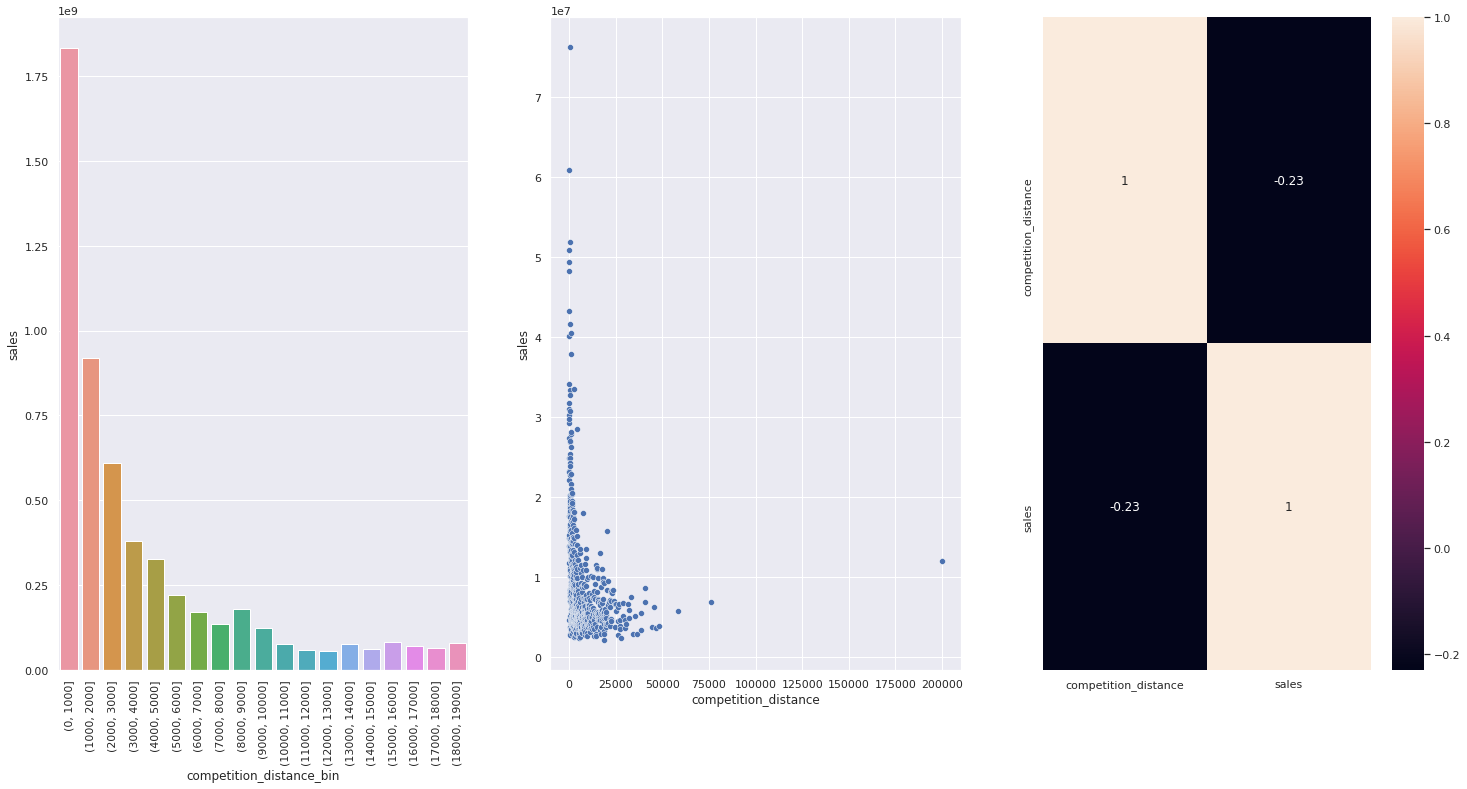

In [178]:
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_bin'] = pd.cut(aux1['competition_distance'], bins)

aux2 = aux1.groupby('competition_distance_bin').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux2, x='competition_distance_bin', y='sales');
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.scatterplot(data=aux1, x='competition_distance', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

**Falsa:** Lojas com competidores a mais tempo vendem menos.

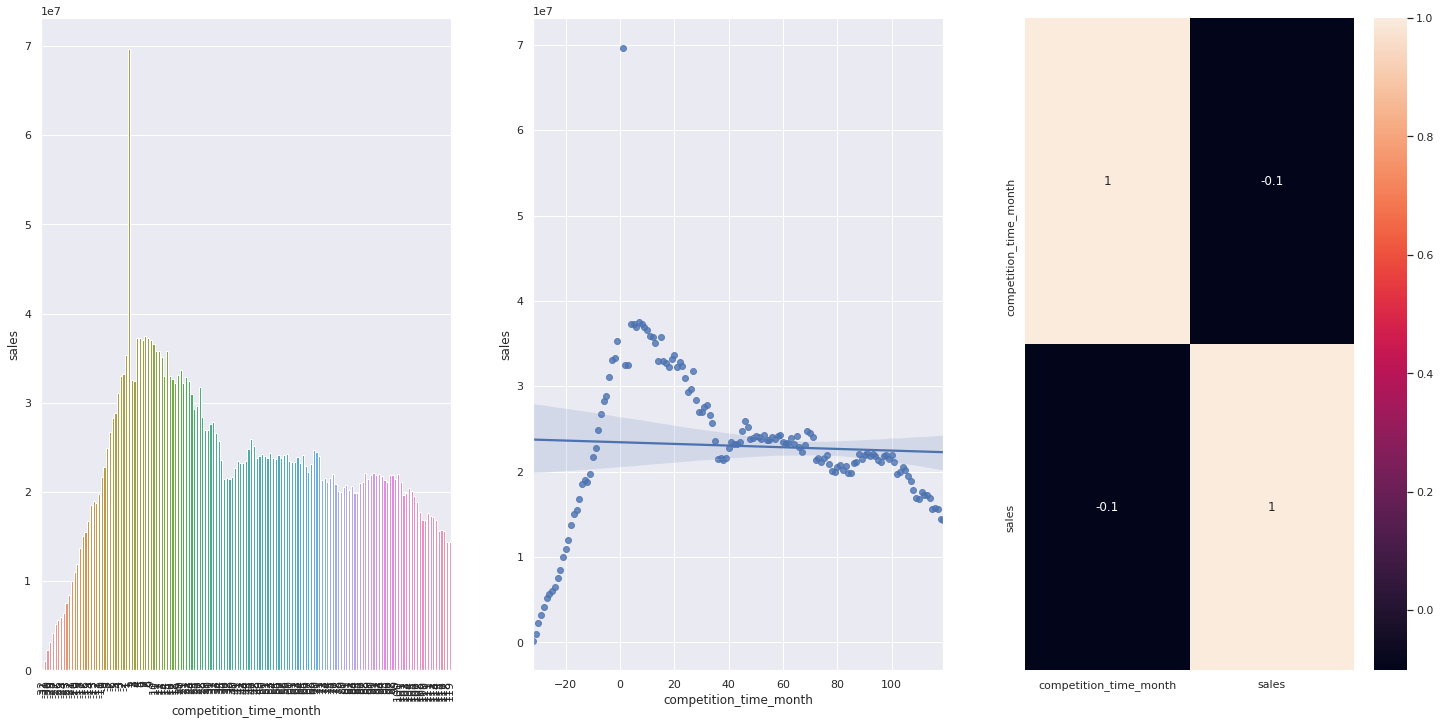

In [188]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3 Análise multivariada